In [59]:
import xarray
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt  # plotting library
import matplotlib.patches as mpatches # draw domain boundry patches

# Issue: Maybe downgrade shapely pip install shapely==1.8.5
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature # for coastlines

# Conversion

Units: meter/year (per year does not make sense though)
mm w.e. (= kg/m^2)  
916.7 kg/m3 (density of ice)  
Convert by multiplying by 916.7 (or 1000 * 0.917)

In [49]:
ice_density = 0.9167

In [82]:
amb = xarray.open_dataset(
    "/home/kim/grace_convNP/data/alt/C3S_AntIS_RA_SEC_vers3_2023-01-16.nc")
gmb = xarray.open_dataset(
    "/home/kim/grace_convNP/data/GRACE_COST-G/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

In [83]:
amb.surface_type.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [88]:
amb.sec.values[60:80, 60:80, -10]

array([[-0.1882006 , -0.35746756, -0.07639121,  0.04088956, -0.07276651,
        -0.317866  , -0.10026035, -0.13556135, -0.2870374 , -0.04354102,
        -0.2592056 , -0.31090114, -0.04373115, -0.44046775, -0.38543665,
        -0.1980528 , -0.11080632, -0.6360656 , -0.07767913, -0.62395084],
       [-0.18289591, -0.13759252, -0.9507459 , -0.22476974, -0.1181625 ,
        -0.01850674, -0.25679976, -0.27107695, -0.29680327, -0.13412638,
        -0.09699708, -0.5555699 , -0.25359416, -0.40755004, -0.22293405,
        -0.30136847, -0.45036972, -0.7367269 , -0.08214236, -0.02496146],
       [-0.15850559, -0.33009264, -0.3565187 , -0.07414806, -0.42362434,
        -0.2562803 ,  0.07946602, -0.42353228, -0.41746747, -0.17995757,
        -0.36440524, -0.3014736 , -0.45074314, -0.07540099, -0.16045782,
        -0.2187748 , -0.08986636, -0.0948754 ,  0.04069889,  0.01673969],
       [-0.21543263, -0.28973585, -0.31708387, -0.07753539, -0.30509612,
        -0.47238508, -0.34797618, -0.45073366, -

## Regridding onto GRACE grid

In [13]:
# amb is 25k apart, gmb is 50k apart
amb_sec_regridded = amb.sec.interp(
    x = gmb.x,
    y = gmb.y,
)

# Units

In [22]:
amb_sec_regridded[t = '2020-05-02T06:20:37.500000000', 50, 50]

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1335495294.py, line 1)

In [26]:
'2020-05-02T06:20:37.500000000'

'2020-05-02T06:20:37.500000000'

In [30]:
print(amb_sec_regridded[:, :, -10].values)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [52]:
# (* 1000) to convert to mm (per every square meter m^2) mm i.e. (ice equilavent) (volumetric)
# convert to water equivalent: * 0.917 (ice is less dense than water)
xdarray = amb_sec_regridded[:, :, -10] * 1000 * ice_density

In [80]:
xdarray_nan_mask = xdarray.copy()
xdarray_nan_mask.values[pd.isna(xdarray_nan_mask.values)] = 1
xdarray_nan_mask.values[~pd.isna(xdarray_nan_mask.values)] = np.nan

In [54]:
cvals  = [0., 0.15, 0.3, 0.45, 0.5, 1.]
colors = ["#371229", "#B6222B", "#FF8E35", "#FCDC79", "white", "#62C3DB"]

norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))
nasa_cmap = mpl.colors.LinearSegmentedColormap.from_list("", tuples)

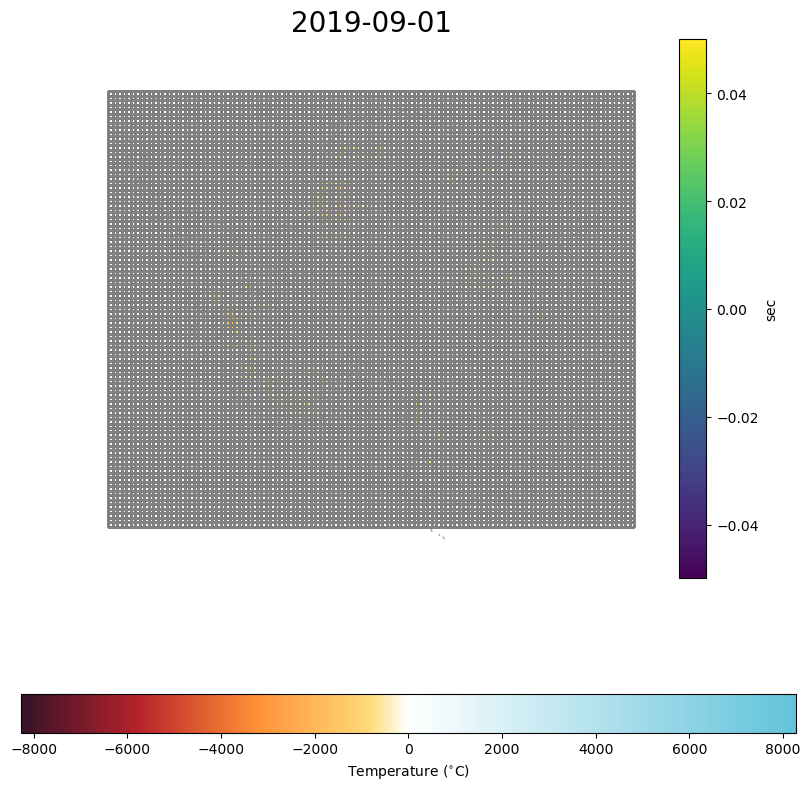

In [81]:
fig = plt.figure(figsize = [10, 10])
ax = plt.axes(projection = ccrs.SouthPolarStereo())

# define bounds
ax.set_extent([-3e6, 3e6, -3e6, 3e6], ccrs.SouthPolarStereo())

# hides boundry line
ax.axis('off')

special_color = 'grey'

# thin coastline lines
ax.add_feature(cfeature.COASTLINE, 
               edgecolor = special_color, 
               linestyle = '-', 
               linewidth = 0.5, 
               alpha = 0.7)

# ax.stock_img()

xdarray.plot(ax = ax, 
        transform = ccrs.SouthPolarStereo(), 
        vmin = np.nanmin(gmb.dm.values), 
        # define max as negative min to keep 0 white
        vmax = -np.nanmin(gmb.dm.values),
        # cmap = 'bwr_r',
        cmap = nasa_cmap,
        # remove colorbar
        add_colorbar = True,
        cbar_kwargs = dict(orientation = 'horizontal',
                      pad = 0.15, shrink = 1, label = 'Temperature ($^{\circ}$C)')) 

xdarray_nan_mask.plot(ax = ax, 
                      transform = ccrs.SouthPolarStereo(),
                      color = "grey")

plt.title(str(xdarray.time)[36:46], size = 20)

plt.show()

In [47]:
xdarray = gmb.dm[-52]

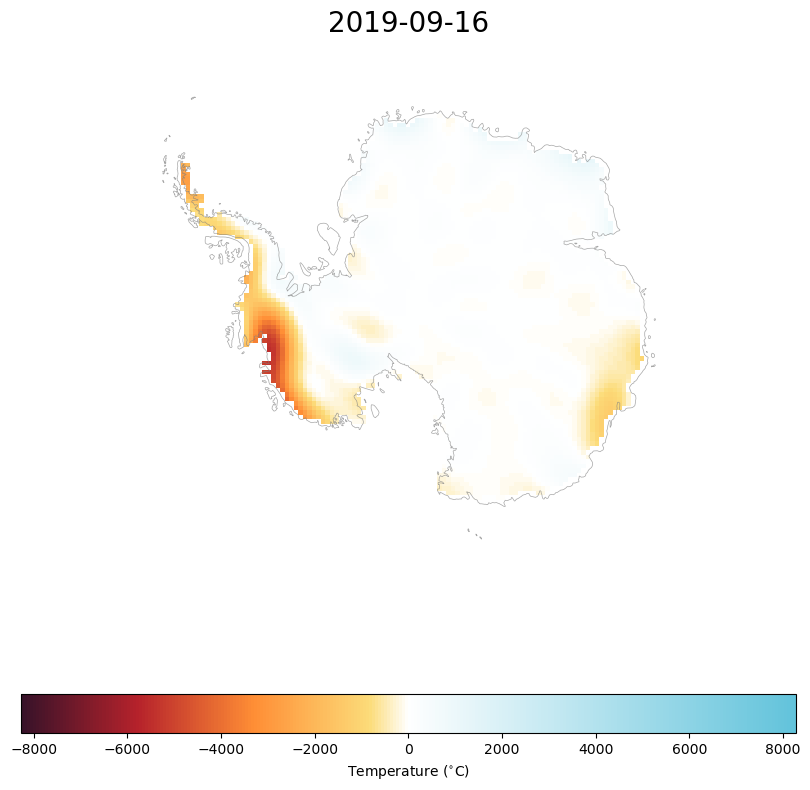

In [48]:
fig = plt.figure(figsize = [10, 10])
ax = plt.axes(projection = ccrs.SouthPolarStereo())

# define bounds
ax.set_extent([-3e6, 3e6, -3e6, 3e6], ccrs.SouthPolarStereo())

# hides boundry line
ax.axis('off')

special_color = 'grey'

# thin coastline lines
ax.add_feature(cfeature.COASTLINE, 
               edgecolor = special_color, 
               linestyle = '-', 
               linewidth = 0.5, 
               alpha = 0.7)

# ax.stock_img()

xdarray.plot(ax = ax, 
        transform = ccrs.SouthPolarStereo(), 
        vmin = np.nanmin(gmb.dm.values), 
        # define max as negative min to keep 0 white
        vmax = -np.nanmin(gmb.dm.values),
        # cmap = 'bwr_r',
        cmap = nasa_cmap,
        # remove colorbar
        add_colorbar = True,
        cbar_kwargs = dict(orientation = 'horizontal',
                      pad = 0.15, shrink = 1, label = 'Temperature ($^{\circ}$C)')) 

plt.title(str(gmb.dm[-51].time)[36:46], size = 20)

plt.show()